# Model training for chunked dataset

We train the model on the chunked dataset. Each image is 15s in duration and ~7km in distance (~70km sliced up into 10 parts)

# 0. Setup and imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.functional import F
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
from datetime import datetime
from tqdm.auto import tqdm

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Data directory
root_dir = '../data/south_dist_chunked_10000to47495_dx5_fs100_bpf14to35Hz/'

# Timestamp to add to output files
timestamp = datetime.now().strftime("%Y_%m_%dT%H%M%S")

torch.manual_seed(42)

/Users/hridaybaghar/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Loading dataset and setting up pre-processing

In [2]:
# Writing a dataloader to load image data from ../data/ folder

class DASImageDataset(Dataset):
    def __init__(self, root_dir, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.files = os.listdir(self.root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_file =(os.path.join(self.root_dir, self.files[index]))
        img = Image.open(img_file)
        
        if self.transform:
            img = self.transform(img)
        
        return img, self.files[index]

In [3]:
# Applying custom convolution kernel to the image

class HorizontalEdge(object):
    def __init__(self):
        
        self.kernel = torch.tensor([[-1, -4, -1],
                                        [0, 0, 0],
                                        [1, 4, 1]], dtype=torch.float32)
    
    def __call__(self, img):
        # Applying 3x3 convolution kernel to the image
        img = F.conv2d(img.unsqueeze(0), self.kernel.unsqueeze(0).unsqueeze(0), padding=1)
        # Using sigmoid to get values between 0 and 1
        img = torch.sigmoid(img)
        # Binarizing the image
        img = (img > 0.54)*1.0
    
        return img.squeeze(0)

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.GaussianBlur(3, sigma=1),
    transforms.ToTensor(),
    HorizontalEdge(),
])

images = DASImageDataset(root_dir=root_dir, transform=transform)

# Train test split - Using 50% of randomly selected images for training and 50% for testing
train_len = int(0.5 * len(images))
test_len = len(images) - train_len

train_dataset, test_dataset = random_split(images, [train_len, test_len])

# Creating dataloaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=RandomSampler(train_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=64, sampler=RandomSampler(test_dataset))
dataloader = {'train': train_dataloader, 'test': test_dataloader}

In [5]:
def view_batch(batch):
    """Function to view a batch of images"""

    grid = make_grid(batch, nrow=8, padding=5)
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()

def view_image(img):
    """Function to view a single image"""
    img = img.squeeze()
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='binary_r')
    plt.show()

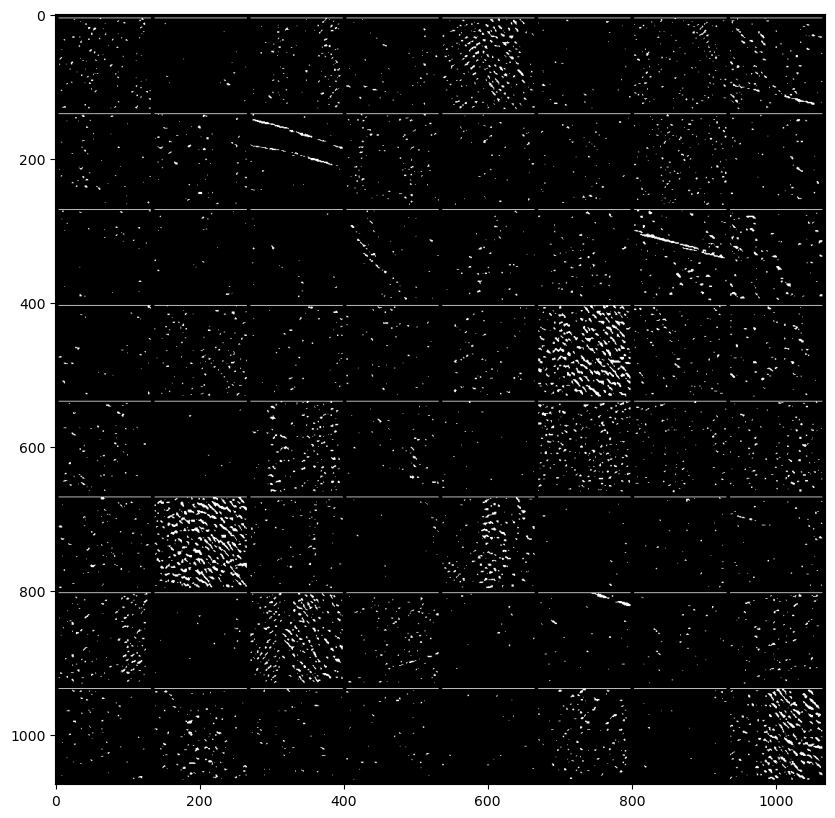

('2021-11-02T16:13:29.834000000_start20419.0.png', '2021-11-02T07:11:14.834000000_start51047.5.png', '2021-11-03T01:41:29.834000000_start89333.125.png', '2021-11-03T05:53:29.834000000_start51047.5.png', '2021-11-02T12:47:14.834000000_start28076.125.png', '2021-11-02T04:19:14.834000000_start58704.625.png', '2021-11-03T10:02:59.834000000_start20419.0.png', '2021-11-03T17:38:14.834000000_start35733.25.png', '2021-11-02T02:14:59.834000000_start58704.625.png', '2021-11-03T06:02:59.834000000_start74018.875.png', '2021-11-02T20:01:59.834000000_start43390.375.png', '2021-11-03T05:22:29.834000000_start20419.0.png', '2021-11-03T05:57:44.834000000_start81676.0.png', '2021-11-03T05:59:44.834000000_start74018.875.png', '2021-11-03T06:11:29.834000000_start20419.0.png', '2021-11-03T18:56:14.834000000_start66361.75.png', '2021-11-02T20:15:59.834000000_start66361.75.png', '2021-11-02T22:22:44.834000000_start66361.75.png', '2021-11-02T06:38:44.834000000_start81676.0.png', '2021-11-03T06:50:14.834000000_

In [6]:
for batch, _ in train_dataloader:
    view_batch(batch)
    print(_)
    break

# 2. Building model

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section

        # Define for 128x128 images
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 8, stride=2, padding=3), # (128 - 8 + 2*3)/2 + 1 = 64
            nn.ReLU(True),
            nn.Conv2d(8, 16, 8, stride=2, padding=3), # (64 - 8 + 2*3)/2 + 1 = 32
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 8, stride=2, padding=3), # (32 - 8 + 2*3)/2 + 1 = 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 8, stride=2, padding=3), # (16 - 8 + 2*3)/2 + 1 = 8
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(8 * 8 * 64, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 8 * 8 * 64),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(64, 8, 8))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 8, stride=2, padding=3), # (8 - 1)*2 - 2*1 + 4 = 16
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 8, stride=2, padding=3), # (16 - 1)*2 - 2*1 + 4 = 32
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 8, stride=2, padding=3), # (32 - 1)*2 - 2*1 + 4 = 64
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 8, stride=2, padding=3) # (64 - 1)*2 - 2*1 + 4 = 128
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [8]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, verbose=True):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the file names (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if verbose:
            print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data



In [9]:
def plot_ae_outputs(encoder,decoder,dataset,n=10):
    
    """Plot the original images and the reconstructed images"""

    plt.figure(figsize=(16,4.5))
    
    # Select n random images from the dataset
    t_idx = np.random.randint(0,len(dataset),n)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      
      # Plot results
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      
      if i == n//2:
        ax.set_title('Original images')
      
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      
      if i == n//2:
         ax.set_title('Reconstructed images')
    
    plt.show() 

# 3. Train the model

In [10]:
from tqdm.auto import trange

# Model parameters and loss function
loss_fn = nn.MSELoss()
lr = 5e-3

encoded_space_dim = 32
fc2_input_dim = 512
num_epochs = 100

# Create the model
encoder = Encoder(encoded_space_dim,fc2_input_dim).to(device)
decoder = Decoder(encoded_space_dim,fc2_input_dim).to(device)

# Create the optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

diz_loss = {'train_loss':[],'val_loss':[]}
# Train the model
for epoch in trange(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_dataloader,loss_fn,optimizer,verbose=False)
   val_loss = test_epoch(encoder,decoder,device,test_dataloader,loss_fn)
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)

100%|██████████| 100/100 [9:34:29<00:00, 344.69s/it] 


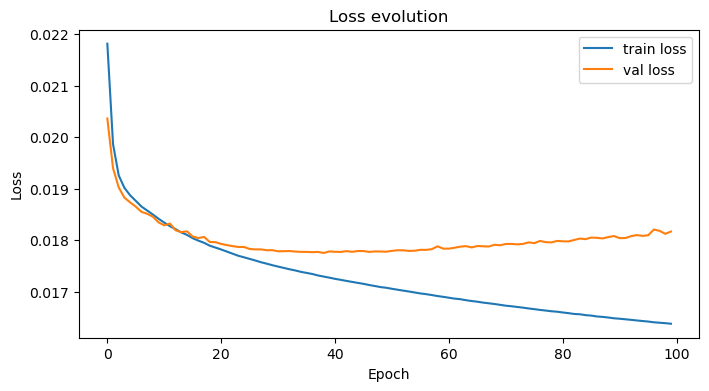

In [11]:
plt.figure(figsize=(8,4))
plt.plot(diz_loss['train_loss'],label='train loss')
plt.plot(diz_loss['val_loss'],label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.legend()

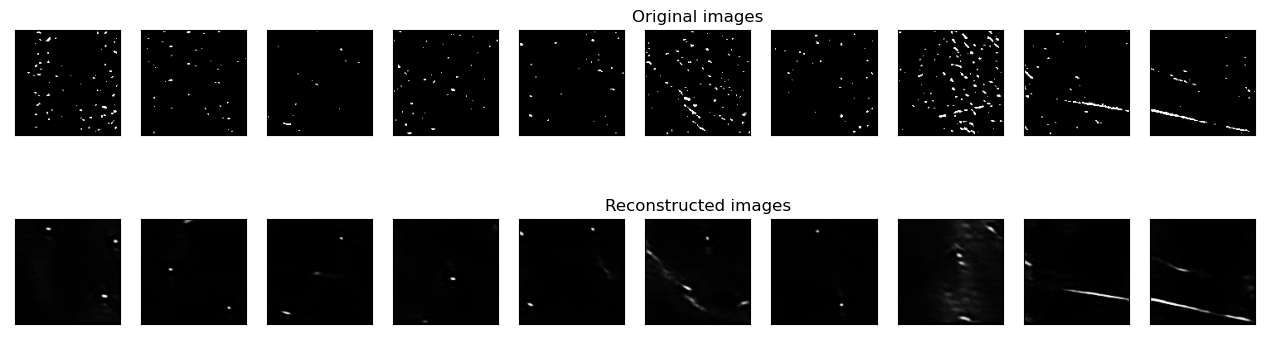

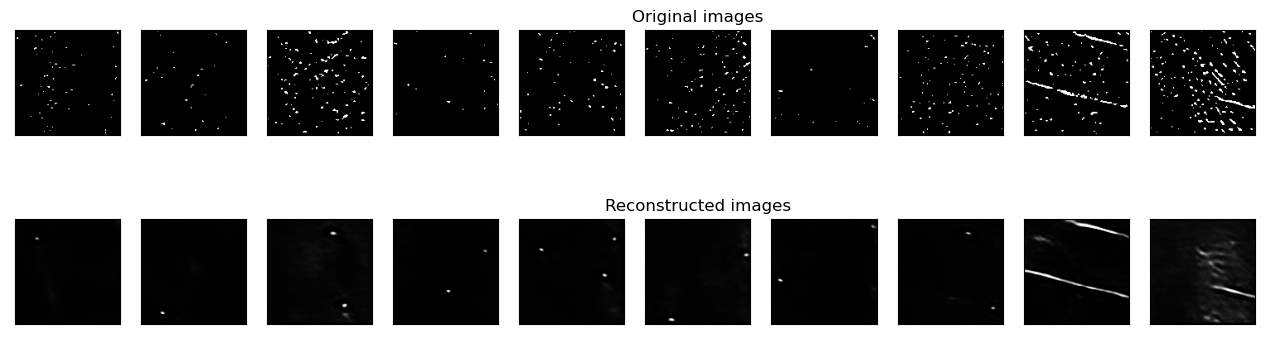

In [12]:
# Plot the results from the model on train and test set
plot_ae_outputs(encoder,decoder,train_dataset,n=10)
plot_ae_outputs(encoder,decoder,test_dataset,n=10)

In [13]:
# Export the model
torch.save(encoder.to('cpu').state_dict(), f'model/encoder_cpu_all_data_{timestamp}.pth')
torch.save(decoder.to('cpu').state_dict(), f'model/decoder_cpu_all_data_{timestamp}.pth')

torch.save(encoder.state_dict(), f'model/encoder_mps_all_data_{timestamp}.pth')
torch.save(decoder.state_dict(), f'model/decoder_mps_all_data_{timestamp}.pth')

# 4. Encoding all the data

Run Sections 0-2 to use saved model and not re-train

In [14]:
# Load encoder and decoder from pth file
encoded_space_dim = 32
fc2_input_dim = 512
encoder = Encoder(encoded_space_dim,fc2_input_dim).to(device)
decoder = Decoder(encoded_space_dim,fc2_input_dim).to(device)
encoder.load_state_dict(torch.load(f'model/encoder_mps_all_data_{timestamp}.pth'))
decoder.load_state_dict(torch.load(f'model/decoder_mps_all_data_{timestamp}.pth'))

<All keys matched successfully>

In [21]:
# Apply the encoder to the whole training and test dataset
encoder.eval()
with torch.no_grad():
    encoded_data = {}
    for set, dl in dataloader.items():
        print(f'Encoding {set} data')
        for image_batch, file_names in tqdm(dl):
            image_batch = image_batch.to(device)
            encoded_data_batch = encoder(image_batch)
            for i in range(len(file_names)):
                encoded_data[file_names[i].split('.png')[0]] = encoded_data_batch[i].cpu().numpy()


Encoding train data


100%|██████████| 1020/1020 [02:03<00:00,  8.25it/s]


Encoding test data


100%|██████████| 1020/1020 [02:04<00:00,  8.16it/s]


In [48]:
df = pd.DataFrame.from_dict(encoded_data, orient='index')
df.reset_index(inplace=True)
df["distance_start"] = df["index"].str.split('_start').str[1]
df["time_start"] = pd.to_datetime(df["index"].str.split('_start').str[0])
df["time_end"] = df["time_start"] + np.timedelta64(15, 's')
df["distance_end"] = df["distance_start"].astype(float) + 7500*5*2.0419/10
df["distance_start"] = df["distance_start"].astype(float).astype(int)
df["distance_end"] = df["distance_end"].astype(float).astype(int)
df.sort_values(by=['time_start', 'distance_start'], inplace=True)
df = df[['time_start', 'time_end', 'distance_start', 'distance_end']+list(range(encoded_space_dim))]
df.to_csv(f'../data/encoded_data_{timestamp}.csv', index=False)

In [49]:
def view_result(time):
    """
    View the result of the autoencoder for a given time

    Parameters
    ----------
    time: str
        Time to be visualized (full or partial timestamp as per file naming convention)
    """

    encoder.eval()
    decoder.eval()

    files = [(i,f) for i,f in enumerate(images.files) if time in f]
    plt.subplots(len(files)*2, 2, figsize=(10, len(files)*2))
    for i,file in enumerate(files):
        img = images[file[0]][0].unsqueeze(0)

        f = file[1].split('_')[0].split('.')[0]+'_'+file[1].split('_')[1].split('.')[0]
    
        plt.subplot(len(files)*2, 2, 1+(i+1-1)*4)
        plt.imshow(img.squeeze(), cmap='binary_r')
        plt.title(f'Input\n{f}')
        plt.axis('off')

        plt.subplot(len(files)*2, 2, 2+(i+1-1)*4)
        encoded = encoder(img.to(device))
        reconstructed = decoder(encoded)
        plt.imshow(reconstructed.squeeze().cpu().detach().numpy(), cmap='binary_r')
        plt.title(f'Reconstructed:\n{f}')
        plt.axis('off')

        plt.subplot(len(files)*2, 2, (3+(i+1-1)*4, 4+(i+1-1)*4))
        plt.imshow(encoded.squeeze().cpu().detach().numpy()[np.newaxis,:], cmap='binary_r')
        plt.title(f'Encoded:\n{f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


/var/folders/rd/v2v17qs50rz2m3cx4yv9ftl40000gn/T/ipykernel_60764/3776075681.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(files)*2, 2, (3+(i+1-1)*4, 4+(i+1-1)*4))


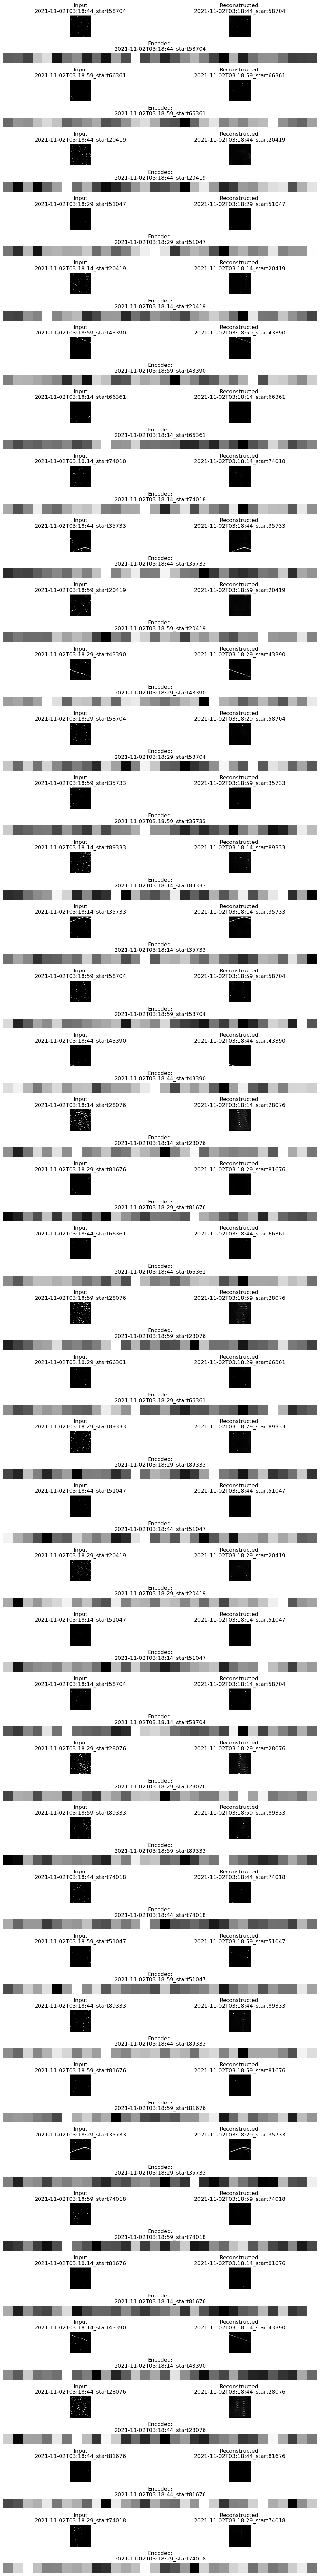

In [50]:
view_result('2021-11-02T03:18')